In [ ]:
import torch
import os

from PIL import Image
from diffusers.models.attention_processor import FluxAttnProcessor2_0
import matplotlib.pyplot as plt

from src.pipeline import RFInversionParallelFluxPipeline
from src.attn_processor import PersonalizeAnythingAttnProcessor, set_flux_transformer_attn_processor
from src.utils import *

/data/hzw/.conda/envs/t2i/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0")
generator = torch.Generator(device=device).manual_seed(18)
torch_type = torch.float16
timestep = 28

DIT_MODEL = "black-forest-labs/FLUX.1-dev"
pipe = RFInversionParallelFluxPipeline.from_pretrained(DIT_MODEL, torch_dtype=torch_type, local_files_only=True).to(device)

height = 1024
width = 1024
latent_h = height // (pipe.vae_scale_factor * 2)
latent_w = width // (pipe.vae_scale_factor * 2)
img_dims = latent_h * latent_w

Loading pipeline components...: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


## Subject Reconstruction + Translation

The mask in the following code can be obtained via segmentation tools. It refers to the region of the reference subject in the reference image, which will be used to extract the specified subject tokens from the reference image tokens.

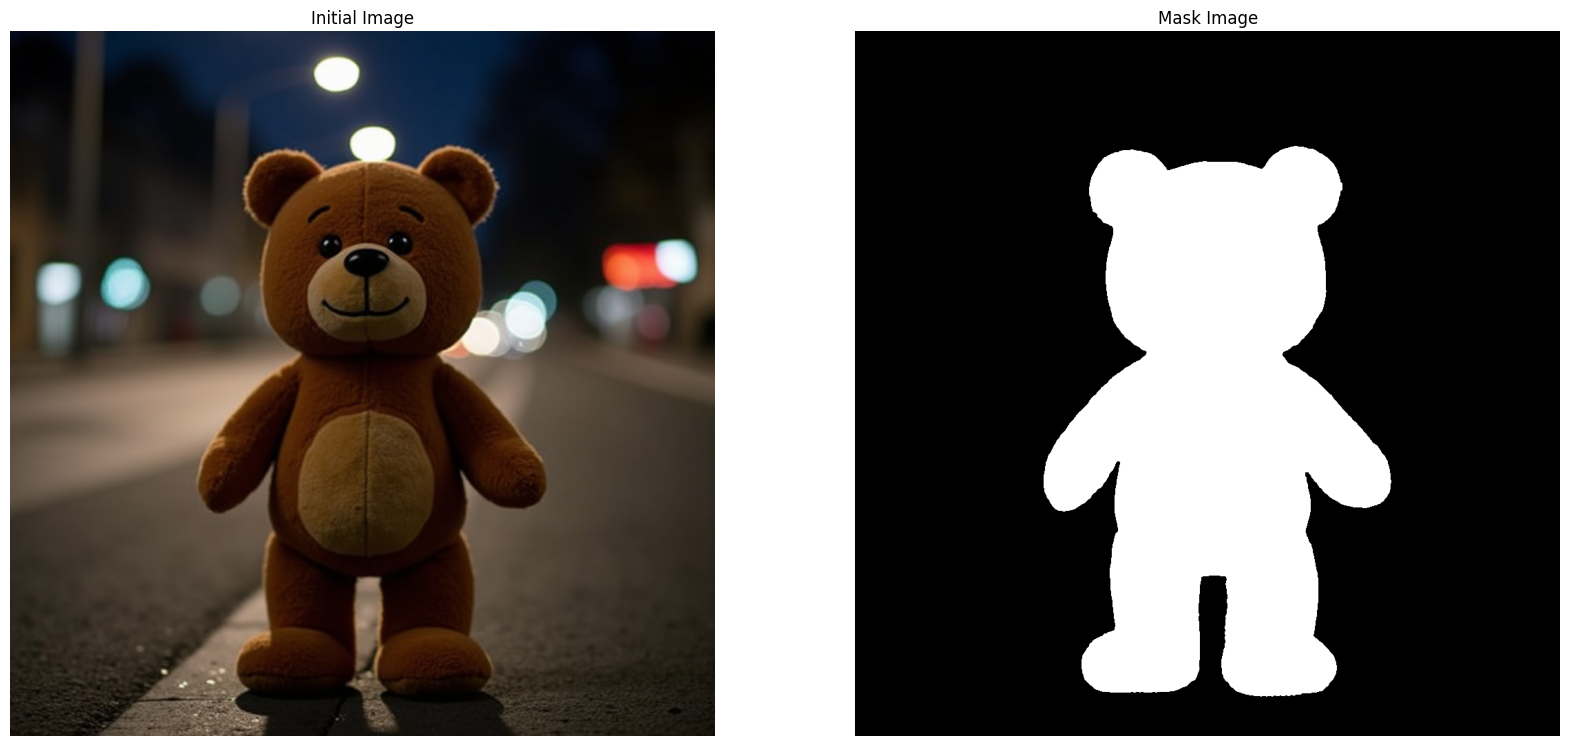

In [3]:
prompt = "A teddy bear"
key_word = "teddy bear"
new_prompt = "A teddy bear on a nighttime street."
tau = 60
shift = -8 # shift the target position in the generated image

key_word_path = key_word.replace(" ", "_")
root_dir = os.path.join("example_data", key_word_path)

# show original image
init_image_path = os.path.join(root_dir, "background.png")
init_image = Image.open(init_image_path).convert('RGB').resize((1024, 1024))

# show mask
mask_path = os.path.join(root_dir, "mask.png")
mask = create_mask(mask_path, latent_w, latent_h)
shift_mask = shift_tensor(mask, shift)    
img_mask = Image.open(mask_path).convert('RGB').resize((width, height))


fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(init_image)
axes[0].axis("off")
axes[0].set_title("Initial Image")

axes[1].imshow(img_mask)
axes[1].axis("off")
axes[1].set_title("Mask Image")

plt.show()

  0%|          | 0/28 [00:00<?, ?it/s]/data/hzw/projects_fhr/personalize-anything/src/pipeline.py:1199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  timestep = torch.tensor(t_i, dtype=Y_t.dtype, device=device).repeat(
100%|██████████| 28/28 [00:33<00:00,  1.21s/it]


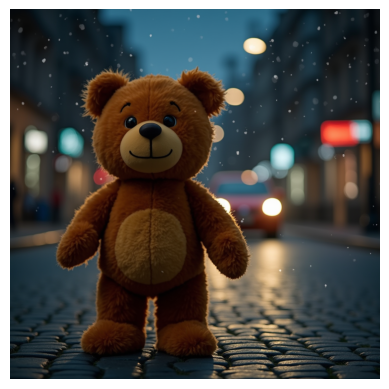

In [4]:
set_flux_transformer_attn_processor(pipe.transformer, set_attn_proc_func=lambda name, dh, nh, ap:FluxAttnProcessor2_0())
inverted_latents, image_latents, latent_image_ids = pipe.invert( 
    source_prompt="", 
    image=init_image, 
    height=height,
    width=width,
    num_inversion_steps=timestep, 
    gamma=1.0,
)

set_flux_transformer_attn_processor(
    pipe.transformer,
    set_attn_proc_func=lambda name, dh, nh, ap: PersonalizeAnythingAttnProcessor(
        name=name, tau=tau/100, mask=mask, shift_mask=shift_mask, device=device, img_dims=img_dims),
)

image = pipe(
    [prompt, new_prompt], 
    inverted_latents=inverted_latents,
    image_latents=image_latents,
    latent_image_ids=latent_image_ids,
    height = height,
    width = width,
    start_timestep=0.0, 
    stop_timestep=0.99,
    num_inference_steps=timestep,
    eta=1.0, 
    generator=generator,
).images[1]

plt.imshow(image)
plt.axis("off")
plt.show()

## Subject Personalization with Manual Perturbation

Pay attention to the specified mask in this section, which is different from that in the "subject reconstruction". Here we show an example of manually perturbing the mask. For instance, to raise the teddy bear's right hand, just remove the right hand part from the mask and then add a text description to achieve it.

**Our automatic perturbation code has not been released. Stay tuned!**

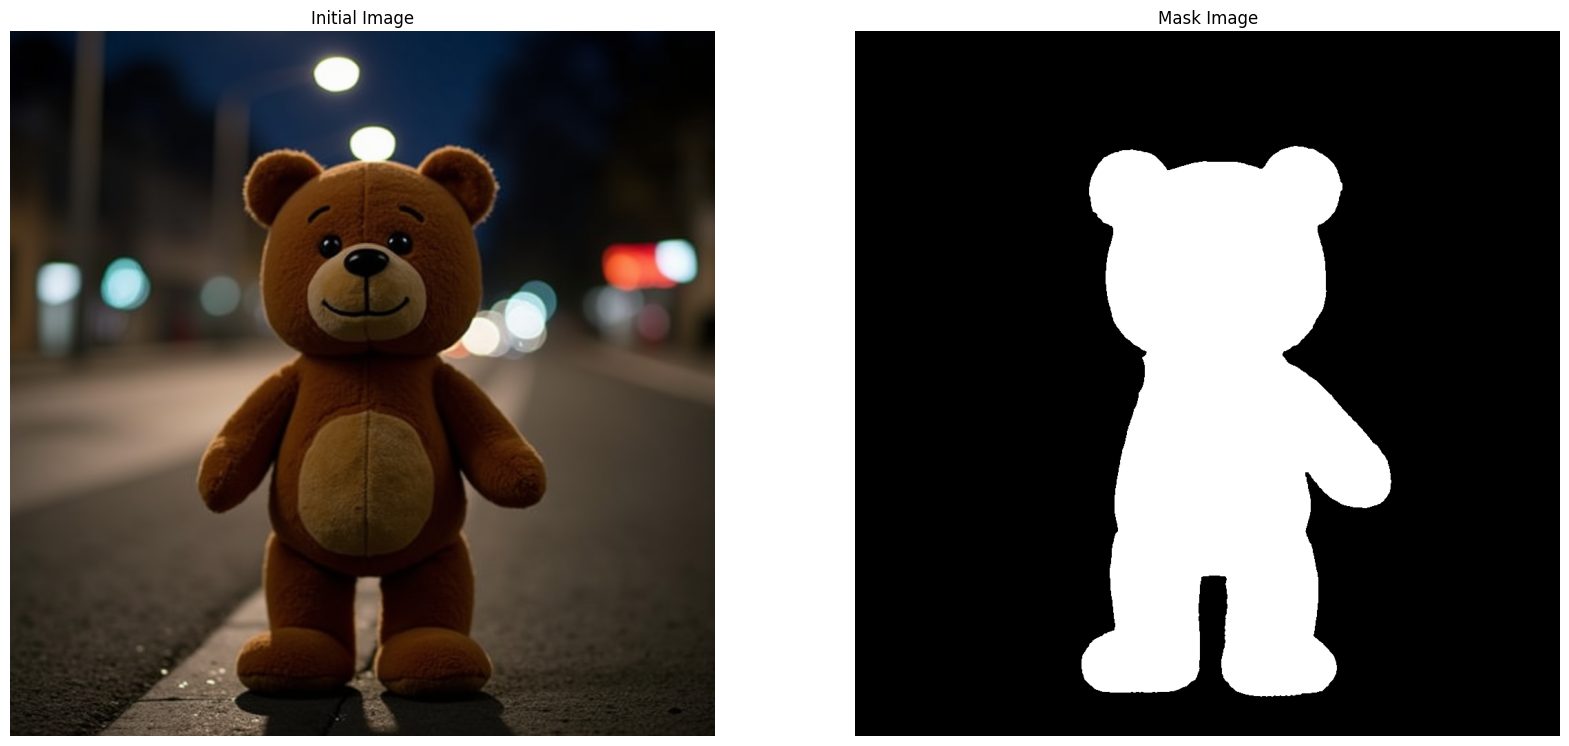

In [5]:
prompt = "A teddy bear"
key_word = "teddy bear "
new_prompt = "A teddy bear waving its right hand on a nighttime street, positioned on the left side of the frame, with an empty road on the right."
tau = 60
shift = 8

key_word_path = key_word.replace(" ", "_")
root_dir = os.path.join("example_data", key_word_path)

# show original image
init_image_path = os.path.join(root_dir, "background.png")
init_image = Image.open(init_image_path).convert('RGB').resize((1024, 1024))

# show mask
mask_path = os.path.join(root_dir, "mask.png")
mask = create_mask(mask_path, latent_w, latent_h)
shift_mask = shift_tensor(mask, shift)    
img_mask = Image.open(mask_path).convert('RGB').resize((width, height))


fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(init_image)
axes[0].axis("off")
axes[0].set_title("Initial Image")

axes[1].imshow(img_mask)
axes[1].axis("off")
axes[1].set_title("Mask Image")

plt.show()

  4%|▎         | 1/28 [00:00<00:09,  2.71it/s]

100%|██████████| 28/28 [00:34<00:00,  1.22s/it]


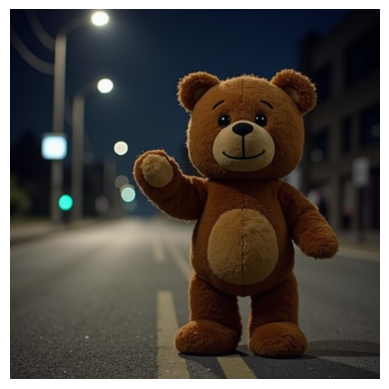

In [9]:
set_flux_transformer_attn_processor(pipe.transformer, set_attn_proc_func=lambda name, dh, nh, ap:FluxAttnProcessor2_0())
inverted_latents, image_latents, latent_image_ids = pipe.invert( 
    source_prompt="", 
    image=init_image, 
    height=height,
    width=width,
    num_inversion_steps=timestep, 
    gamma=1.0,
)

set_flux_transformer_attn_processor(
    pipe.transformer,
    set_attn_proc_func=lambda name, dh, nh, ap: PersonalizeAnythingAttnProcessor(
        name=name, tau=tau/100, mask=mask, shift_mask=shift_mask, device=device, img_dims=img_dims),
)

image = pipe(
    [prompt, new_prompt], 
    inverted_latents=inverted_latents,
    image_latents=image_latents,
    latent_image_ids=latent_image_ids,
    height = height,
    width = width,
    start_timestep=0.0, 
    stop_timestep=0.99,
    num_inference_steps=timestep,
    eta=1.0, 
    generator=generator,
).images[1]

plt.imshow(image)
plt.axis("off")
plt.show()